In [ ]:
import pandas as pd

In [ ]:
df_listing = pd.read_csv("data/Antwerp/data/listings.csv")

In [ ]:
df_listing.info()

### Calculez le nombre d’host et le nombre de review par quartier. (​​neighbourhood_cleansed)?

In [ ]:
nombre_host = df_listing.groupby('neighbourhood_cleansed').host_id.nunique()

In [ ]:
nombre_review = df_listing.groupby('neighbourhood_cleansed').number_of_reviews.sum()

In [198]:
res = pd.concat([nombre_host,nombre_review], axis = 1)
res.head()

,host_id,number_of_reviews
neighbourhood_cleansed,,
Amandus - Atheneum,125,6356
Borgerhout Extra Muros,34,1219
Borgerhout Intra Muros Noord,50,2676
Borgerhout Intra Muros Zuid,57,2556
Brederode,61,1359


# Question 1 : visualization

In [ ]:
res.sort_values("host_id", ascending=True)

In [178]:
import matplotlib.pyplot as plt
import numpy

/tmp/ipykernel_277055/1833931285.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x,rotation=90)


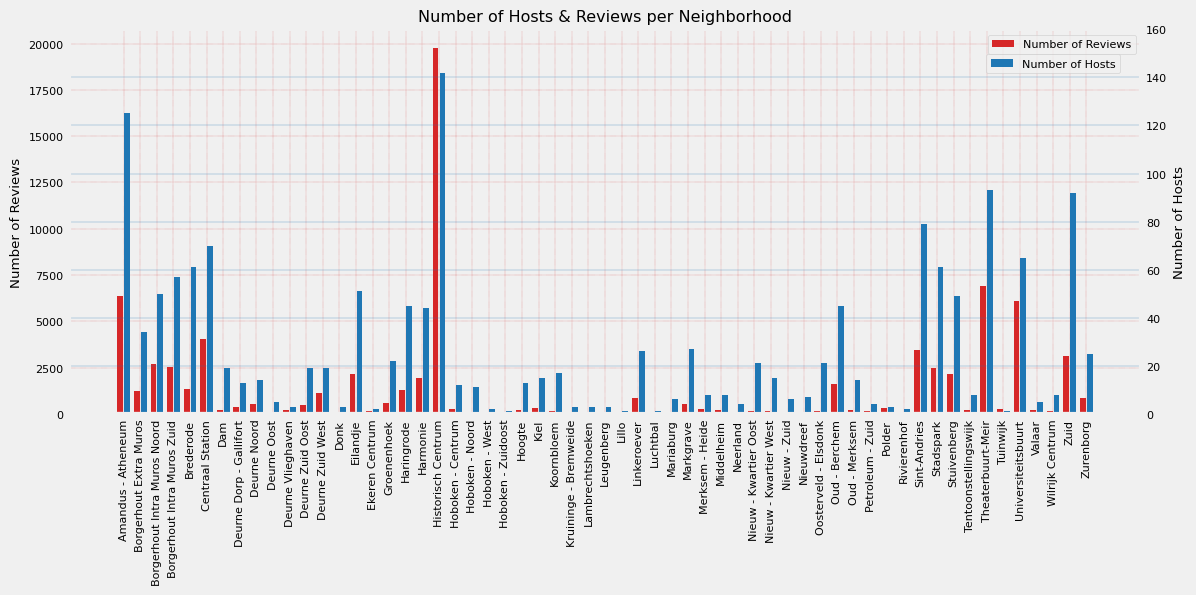

In [326]:
# set plot style
plt.style.use('_mpl-gallery')

# set plot font size
plt.rcParams.update({'font.size': 8})

# set the color used for the 2 bars
bar_colors = ['tab:red', 'tab:blue']

# set the width of the bars
width = 0.35

# subdivision of the X axis into as many parts as there is elements on the X axis
x = np.arange(len(res.index))

# get the data for the 2 type of bars
y1 = res["number_of_reviews"]
y2 = res["host_id"]

# create the plot with a given size
fig, ax = plt.subplots(figsize=(12,6))

# creation of a twin X axis
ax2 = ax.twinx()

# creation of the two bar types
rects1 = ax.bar(x-width*1.2/2 ,y1, width, label='Number of Reviews', color=bar_colors[0])
rects2 = ax2.bar(x+width*1.2/2 ,y2, width, label='Number of Hosts', color=bar_colors[1])

# rotate the X labels (90 = vertical)
ax.set_xticklabels(x,rotation=90)

# set plot general title
ax.set_title('Number of Hosts & Reviews per Neighborhood')

# set the ticks (écarts) for the bottom axis
ax.set_xticks(x,list(res.index))
ax2.set_yticks(range(0,170,20))


ax.set_ylabel('Number of Reviews')
ax2.set_ylabel('Number of Hosts')

# set the colors and styles for the inside lines (grid)
ax.grid(color='tab:red', linestyle='dotted', linewidth=0.3)
ax2.grid(color='tab:blue', linestyle='-', linewidth=0.2)

# creation of the legends, (the second one is placed under the top one)
ax.legend()
ax2.legend(bbox_to_anchor=(.985, .95))

# displays the plot in a condensed layout
fig.tight_layout()
plt.savefig("./test2.png")
plt.show()

### Quels sont les pourcentage d’acceptation et de réponse moyen des hosts?

In [118]:
response_percentage = df_listing["host_response_rate"].dropna().apply(lambda x : x.replace("%","")).astype("int").mean()
response_percentage

94.5228426395939

In [114]:
acceptance_percentage = df_listing["host_acceptance_rate"].dropna().apply(lambda x : x.replace("%","")).astype("int").mean()
acceptance_percentage

85.94274623968947

# Question 2 : visualization

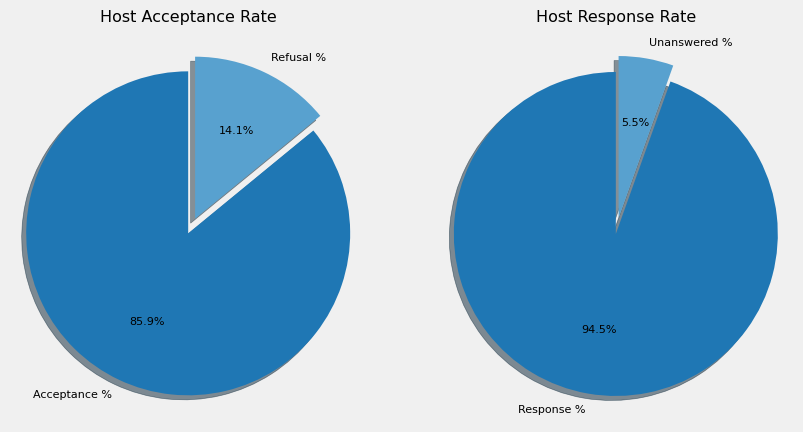

In [146]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels1 = 'Acceptance %', 'Refusal %'
labels2 = 'Response %', 'Unanswered %'
values1 = [acceptance_percentage,100-acceptance_percentage]
values2 = [response_percentage,100-response_percentage]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].pie(values1, explode=explode, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Host Acceptance Rate')

ax[1].pie(values2, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Host Response Rate')

plt.show()

### Quel pourcentage des hosts on une vérification:

- par téléphone
- par email
- par email pro

In [ ]:
verification_dict = {}
for i in df_listing[df_listing["host_verifications"].notnull()]["host_verifications"].apply(eval):
    for j in i:
        if j not in verification_dict:
            verification_dict[j] = 1
        else:
            verification_dict[j] += 1

for key in verification_dict.keys():
    verification_dict[key] =  verification_dict[key] / df_listing.shape[0] 

verification_dict



### En fonction du type de room, calculez le nombre moyen d’amenities et l'écart type.

In [ ]:
df_listing["nb_amenities"] = df_listing["amenities"].apply(eval).apply(len)

In [ ]:
df_listing[["nb_amenities","room_type"]].groupby("room_type").agg(["mean","std"])

In [ ]:
df_room_type = df_listing[["nb_amenities","room_type"]].groupby("room_type").agg(["mean","std"])
df_room_type.columns = ["nb_aminities_mean","nb_aminities_std"]
df_room_type

### Quel est le prix median par type de room, le maximum, le minimum, le premier et le troisième quartile?

In [ ]:
df_listing["clean_price"] = df_listing["price"].apply(lambda x: x.replace("$","")) \
                                               .apply(lambda x: x.replace(",","")) \
                                               .astype("float")
           

In [ ]:
df_listing[["clean_price","room_type"]].groupby("room_type").agg(
    median_price=('clean_price', 'median'), 
    max_price=('clean_price', 'max'),
    min_price=('clean_price', 'min'),
    first_quartile_price=('clean_price',lambda x:x.quantile(0.25)),
    third_quartile_price=('clean_price', lambda x:x.quantile(0.75)),
    )

### Si on considère qu’un "bath" vaut 1,  qu’une bath shared vaut 0.5 et qu’un private bath vaut 2. Combien y-a-t-il d’annonces par valeur de salle de bain. (0.5 / 1 / 1.5 ….)?

In [ ]:
def valeur_salle_de_bain(x):
    x_list = x.split(" ")
    x_value = 1
    mapper = {"bath":1, "baths":1, "private":2, "shared":0.5, "half-bath":0.5}
    for element in x_list:
        try: 
            x_value *= float(element)
        except:
            x_value *= mapper[element.lower()]
    return x_value

valeur_salle_de_bain("1.5 shared baths")

In [232]:
df_listing["bathrooms_text"].dropna().apply(valeur_salle_de_bain).value_counts().sort_index(ascending=True)

0.00       3
0.25       6
0.50     136
0.75      69
1.00    1086
1.25      10
1.50     626
2.00     196
2.50      47
3.00      22
3.50      11
4.00       5
5.00       2
6.50       2
7.00       1
7.50       1
8.00       1
8.50       1
Name: bathrooms_text, dtype: int64

In [ ]:
df_listing.info()

In [ ]:
df_listing[["bathrooms","bathrooms_text"]]

### Il y a t’il une corrélation entre le nombre de reviews et la taille de la description en terme de nombre de caractères?

In [ ]:
df_cor = df_listing[["description", "number_of_reviews"]].dropna()
df_cor["description_len"] = df_cor["description"].apply(len) 
df_cor[["description_len", "number_of_reviews"]].corr()

### On suspecte des faux commentaires. Pour identifier cela on regarde les séjours où le nom de l’host est le même que le nom du reviewer.  Quel est ce pourcentage général de séjour où le nom de l'host est identique au nom du reviewer?

In [ ]:
df_reviews = pd.read_csv("Data/reviews.csv")

In [ ]:
df_merge = df_reviews.merge(df_listing, how="left", left_on="listing_id", right_on="id")

In [ ]:
df_merge.loc[ df_merge["host_name"].apply(lambda x:x.lower())== df_merge["reviewer_name"].apply(lambda x:x.lower()), ["host_name","reviewer_name"]]

In [ ]:
171/df_merge.shape[0]